In [38]:
#BiocManager::install("topGO")
source(file.path(Sys.getenv("CODEBASE"),"DNAmeth500species/src/00.0_init.R"))
wd = file.path(analysis_dir, "03_motifAnalysis/03.7_AME")
setwd(wd)
outdir = file.path(wd, "GO")
dir.create(outdir)

library(topGO)

tf_db <- read.csv("../JASPAR.csv", sep = ";")

gene_clusters <- read.table("summary/clusters_and_selex.csv", sep = " ", header = 1)

Joining, by = "species"

Warning message in dir.create(outdir):
“'/scratch/lab_bock/shared/projects/compEpi/results_analysis/03_motifAnalysis/03.7_AME/GO' already exists”


In [3]:
library(RColorBrewer)
wd = file.path(analysis_dir, "03_motifAnalysis/03.7_AME/SELEX")
dir.create(wd, recursive = T)
setwd(file.path(analysis_dir, "03_motifAnalysis/03.7_AME/"))

ans <- read.csv("summary/tf_presence.csv", sep = " ", row.names = 1)
head(ans)

Warning message in dir.create(wd, recursive = T):
“'/scratch/lab_bock/shared/projects/compEpi/results_analysis/03_motifAnalysis/03.7_AME/SELEX' already exists”


,ABU,ACT,AFB,AI,AST,BA,BAS,BB,BC,BD,⋯,PO,ROD,SU,TM,TUT,VC,WFA,WHE,WHS,ZE
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ALX3,0,0,-1,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Arid3b,0,0,-1,0,0,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
BARX2,0,0,0,0,0,1,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ELF3,0,0,0,0,0,0,0,-1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ESX1,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GSX1,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
##reading the selex data (Yin et al, S. table 3)
selex <- read.csv(file.path(Sys.getenv("CODEBASE"),"DNAmeth500species/meta/Selex_data.csv"), skip = 20, header = 21, sep = ";") ## data from the paper Yin et al
head(selex)



,TF.name,clone.type,Call,methyl.SELEX.call,bisulfite.call,comment,seed.used.for.bisulfite.SELEX,start.position.of.CG,enrichment.of.mCG,CG.frequency,TG.frequency,CG.frequency.1,TG.frequency.1,CG.frequency.2,TG.frequency.2,CG.frequency.3,TG.frequency.3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ALX3,eDBD,MethylPlus,MethylPlus,low complexity motif,low complexity motif,TTAAYGAW,5,"50,00%","0,10","0,07","0,04","0,19","0,11","0,07","0,06","0,16"
2,CDX4,FL,MethylPlus,MethylPlus,MethylPlus,concordant,NGTYGTAAAWN,4,"59,23%","0,45","0,03","0,13","0,26","0,52","0,02","0,23","0,17"
3,CDX4,eDBD,MethylPlus,MethylPlus,MethylPlus,concordant,NGTYGTAAAAN,4,"164,71%","0,27","0,02","0,04","0,16","0,31","0,02","0,12","0,10"
4,CEBPB,eDBD,MethylPlus,Little effect,weak MethylPlus,effect revealed by bisulfite,NRTTGYGYAAYN,6,"14,83%","0,54","0,10","0,29","0,44","0,61","0,09","0,37","0,41"
5,CEBPE,eDBD,MethylPlus,Little effect,weak MethylPlus,effect revealed by bisulfite,NRTTGYGYAAYN,6,"12,01%","0,60","0,07","0,31","0,41","0,71","0,06","0,40","0,39"
6,CEBPG,FL,MethylPlus,Little effect,weak MethylPlus,effect revealed by bisulfite,NTTGYGYAAN,5,"20,07%","0,31","0,09","0,17","0,32","0,37","0,10","0,23","0,30"


In [9]:
length(intersect(row.names(ans), selex$TF.name))

TF_meth <- data.frame(row.names(ans))
colnames(TF_meth) <- c("TF")

TF_meth$TF_upd <- unlist(sapply(as.character(TF_meth$TF), function(x) strsplit(x,"\\(")[[1]][1]))

[1] 211

In [11]:
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
musGenes <- TF_meth$TF_upd[sapply(TF_meth$TF_upd, function(x) x!=toupper(x))]
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", musGenes, mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <- setNames(genesV2[, 2], genesV2[, 1])

Loading required package: biomaRt



In [12]:
TF_meth$TF_upd <- unlist(sapply(TF_meth$TF_upd, function(x){if(x %in% names(humanx)) return(humanx[[x]]) 
                                                                        else return(x)}))
length(intersect(TF_meth$TF_upd, selex$TF.name))

TF_meth <- unique(left_join(TF_meth, selex[, c("TF.name","clone.type", "Call")], by = c("TF_upd" = "TF.name")))



[1] 227

In [13]:
##now lets assume that all the little effects and inconclusive can be united with undefined into grey area
TF_meth$Call_upd <- sapply(as.character(TF_meth$Call), 
                           function(x){if(!is.na(x) & (x=="MethylPlus"|x=="MethylMinus")) return(x)
                                                                      else return("undefined/unknown")})

In [19]:
annot_col = as.data.frame(sp_df$color_class)
row.names(annot_col) <- row.names(sp_df)
colnames(annot_col) <- c("class")

color=c(tissue_colors["L"], "#f7f7f7", tissue_colors["H"])
breaks=c(-2, -1,0,1)

In [14]:
##add TF family annotation
tf_annot <- read.csv("../JASPAR.csv", sep = ";")
all_tf <- row.names(ans)
head(tf_annot)
my_tf_annot <- unique(tf_annot[tf_annot$Name %in% all_tf, c("Name", "Class", "Family")])
row.names(my_tf_annot) <- my_tf_annot$Name
my_tf_annot$Family <- as.character(my_tf_annot$Family)

new_f <- sapply(my_tf_annot$Family, function(x) strsplit(x, "::")[[1]])
my_tf_annot$Family_short<-as.character(sapply(new_f, function(x) x[length(x)]))

new_c <- sapply(as.character(my_tf_annot$Class), function(x) strsplit(x, "::")[[1]])
my_tf_annot$Class_short<-as.character(sapply(new_c, function(x) x[length(x)]))


my_tf_annot <- my_tf_annot[order(my_tf_annot$Class_short),]
my_tf_annot$Family_short <- factor(my_tf_annot$Family_short, levels = unique(my_tf_annot$Family_short))

my_tf_annot_upd <- left_join(my_tf_annot, unique(TF_meth[, c("TF", "TF_upd", "Call_upd")]), by = c("Name" = "TF"))

,ID,Name,Species,Class,Family,Logo,X,X.1,X.2,X.3,X.4,X.5
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MA0004.1,Arnt,Mus musculus,Basic helix-loop-helix factors (bHLH),PAS domain factors,NA,,,,,,
2,MA0006.1,Ahr::Arnt,Mus musculus,Basic helix-loop-helix factors (bHLH)::Basic helix-loop-helix factors (bHLH),PAS domain factors::PAS domain factors,NA,,,,,,
3,MA0007.1,Ar,Rattus rattus,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors (NR3),NA,,,,,,
4,MA0007.2,AR,Homo sapiens,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors (NR3),NA,,,,,,
5,MA0007.3,Ar,Mus musculus,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors (NR3),NA,,,,,,
6,MA0018.1,CREB1,Homo sapiens,Basic leucine zipper factors (bZIP),CREB-related factors,NA,,,,,,


In [15]:
##BCL6
id_to_drop <- c(row.names(my_tf_annot_upd[my_tf_annot_upd$Name=="BCL6" & my_tf_annot_upd$Call_upd=="undefined/unknown",]))

id_to_drop <- c(id_to_drop, row.names(my_tf_annot_upd[my_tf_annot_upd$Name=="KLF17" & 
                                          my_tf_annot_upd$Call_upd=="undefined/unknown",]))
id_to_drop <- c(id_to_drop, row.names(my_tf_annot_upd[my_tf_annot_upd$Name=="PAX7" & 
                                                        my_tf_annot_upd$Call_upd!="undefined/unknown",]))
id_to_drop



[1] "105" "130" "443" "444"

In [16]:
my_tf_annot_upd <- my_tf_annot_upd[-as.integer(id_to_drop),]
row.names(my_tf_annot_upd) <- my_tf_annot_upd$Name

In [17]:
#creating a distinct color palette
n <- length(unique(my_tf_annot$Class_short))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

Class_idst_col<-setNames(sample(col_vector, n), unique(my_tf_annot$Class_short))
write.csv(as.data.frame(Class_idst_col), "classes_color_annot.csv", quote = F)
write.table(my_tf_annot_upd, "SELEX/annotation_TFs.csv",sep = ",", row.names = F )
my_colors <- list(class = class_colors, Class_short = Class_idst_col, 
                  Call_upd = c("MethylPlus" = "red", "MethylMinus" = "#006837", "undefined/unknown" = "grey"))

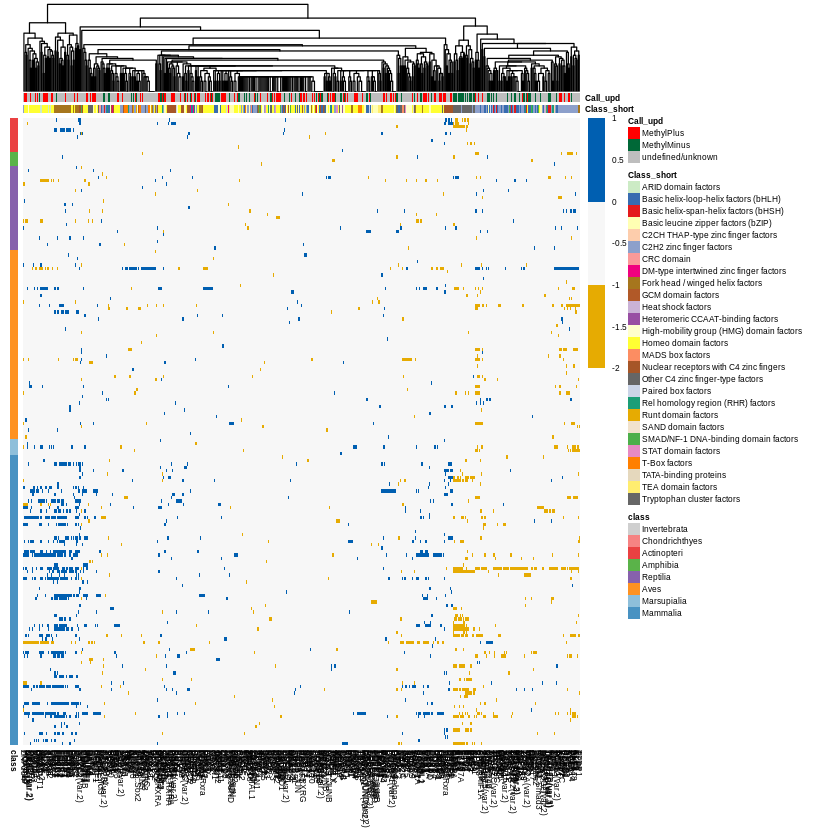

In [20]:
pheatmap(t(ans[,sp_df$species[sp_df$species %in% colnames(ans)]]), 
         cluster_rows = F,annotation_row = annot_col, annotation_col = my_tf_annot_upd[, c(5,7)],
         annotation_colors = my_colors, show_rownames = F,
         fontsize = 5, annotation_legend = T , breaks = breaks, color = color)

In [21]:
tf_to_keep <- names(rowSums(abs(ans))[rowSums(abs(ans)) >= 10])
ans_f <- ans[tf_to_keep,]
sp_to_keep <- names(colSums(abs(ans_f))[colSums(abs(ans_f)) >= 5])
ans_f <- ans_f[,sp_to_keep]
f <- unique(my_tf_annot[my_tf_annot$Name %in% row.names(ans_f),]$Family_short)
my_colors <- list(class = class_colors, 
                  Call_upd = c("MethylPlus" = "red", "MethylMinus" = "#006837", "undefined/unknown" = "grey"),
                  Class_short = Class_idst_col[unique(my_tf_annot[my_tf_annot$Name %in% row.names(ans_f),]$Class_short)])



In [23]:
dev.off()
pdf("summary/final_heatmaps/TFBS_presence_turned_filtered_selex1.pdf", width = 15, height = 10)
pheatmap(t(ans_f), 
         annotation_row = annot_col, annotation_col = my_tf_annot_upd[,  c(5,7)],
         annotation_colors = my_colors, show_rownames = F,
         fontsize = 10, breaks = breaks, color = color)
dev.off()

null device 
          1

null device 
          1

Joining, by = "TF"



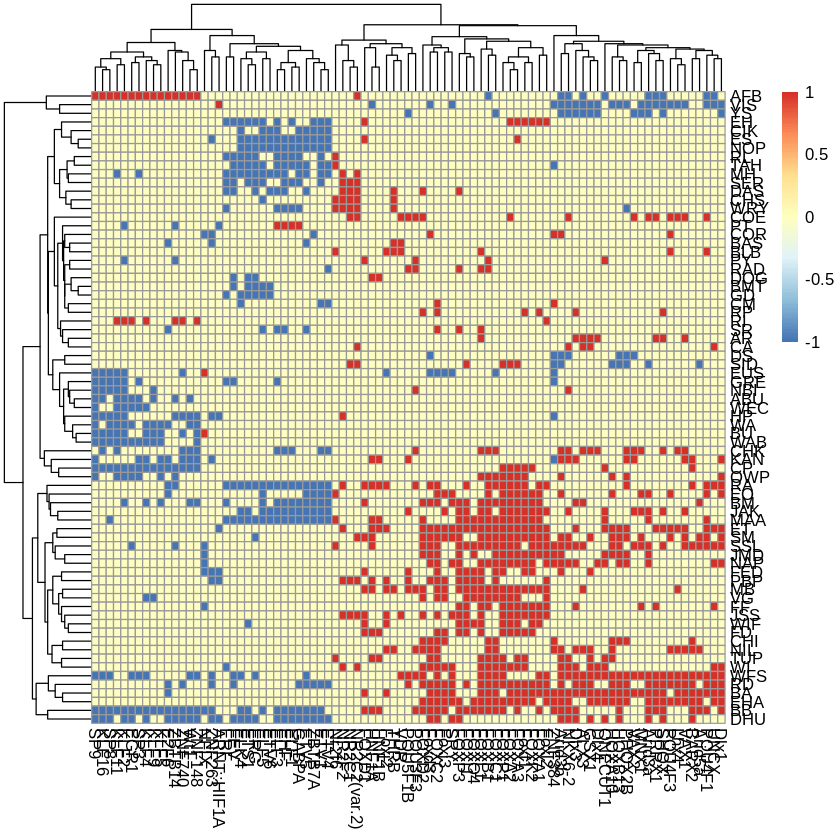

In [25]:
ph <- pheatmap(t(ans_f))

tf_tree <- ph$tree_col
cl <- cutree(tf_tree, k = 2)
df <- as.data.frame(cl)
df$TF <- row.names(df)
df <- left_join(df, TF_meth[, c("TF", "TF_upd", "Call_upd")])

write.table(df, "summary/clusters_and_selex1.csv", row.names = F, quote = F)



In [51]:
rownames(ans_f)

[1] "ALX3"         "Arid3b"       "BARX2"        "ELF3"         "GSX1"        
 [6] "HOXB13"       "Lhx4"         "NKX6-2"       "PHOX2B"       "PRRX1"       
[11] "SHOX"         "UNCX"         "EGR1"         "KLF11"        "KLF16"       
[16] "KLF2"         "KLF9"         "SP3"          "SP9"          "Wt1"         
[21] "ZBTB14"       "Arid5a"       "HNF1A"        "HNF1B"        "POU4F1"      
[26] "POU4F3"       "POU5F1B"      "Arid3a"       "FOXB1"        "ONECUT1"     
[31] "E2F6"         "ZNF263"       "EHF"          "ELF1"         "ELK4"        
[36] "ETS1"         "GABPA"        "KLF4"         "KLF5"         "NFIX"        
[41] "SP8"          "ZBTB7A"       "ZNF148"       "ZNF740"       "HOXA10"      
[46] "ZNF384"       "ERG"          "Foxd3"        "ARNT::HIF1A"  "VAX2"        
[51] "FOXC1"        "FOXC2"        "Foxj2"        "Foxj3"        "SRY"         
[56] "Dlx1"         "Dlx3"         "Dlx4"         "MNX1"         "VAX1"        
[61] "NR2C1"        "NR2C2(var.2)" "THRB"         "FOXL1"        "FOXA1"       
[66] "FOXA2"        "FOXA3"        "FOXD1"        "Foxf1"        "FOXK2"       
[71] "Foxl2"        "VDR"          "FOXD2"        "FOXI1"        "FOXO4"       
[76] "FOXP1"        "FOXP3"        "POU3F3"       "NR2F2"        "Nr2f6"       
[81] "ELF5"         "ETV1"         "ETV4"         "ETV5"         "ERF"         
[86] "ETV6"         "FEV"

In [28]:
gene_clusters <- df

In [39]:
##applying it to our TFs (all on the human level)
all_tf <- as.character(tf_db$Name)

all_tf <- as.character(sapply(all_tf, function(x) strsplit(x, "[(]")[[1]][1]))

In [40]:
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
musGenes <- all_tf[sapply(all_tf, function(x) x!=toupper(x))]
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", musGenes, mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <- setNames(genesV2[, 2], genesV2[, 1])

In [31]:
##geneID2Symbol
geneID2Name <- read.table("/scratch/lab_bock/dromanovskaia/resources/NCBI/gene2ID_homo_sapiens", sep=";", fill = F, quote="\"")

colnames(geneID2Name) <- c("id", "symbol")
geneName2ID <- setNames(geneID2Name$id, geneID2Name$symbol)

In [41]:
all_tf

[1] "Arnt"                "Ahr::Arnt"           "Ar"                 
   [4] "AR"                  "Ar"                  "CREB1"              
   [7] "CREB1"               "CREB1"               "CREB1"              
  [10] "Ddit3::Cebpa"        "E2F1"                "E2F1"               
  [13] "E2F1"                "En1"                 "EN1"                
  [16] "ELK1"                "ELK1"                "FOXF2"              
  [19] "FOXD1"               "FOXC1"               "FOXC1"              
  [22] "Foxd3"               "FOXI1"               "FOXI1"              
  [25] "Foxa2"               "Foxa2"               "FOXA2"              
  [28] "ELK4"                "ELK4"                "ETS1"               
  [31] "Ets1"                "ETS1"                "FOS::JUN"           
  [34] "FOS::JUN"            "Cebpa"               "CEBPA"              
  [37] "CEBPA"               "CEBPA"               "ESR1"               
  [40] "ESR1"                "ESR1"                "ELF5"               
  [43] "ELF5"                "CTCF"                "Esrrb"              
  [46] "Esrrb"               "ESRRB"               "FOXA1"              
  [49] "FOXA1"               "FOXA1"               "FOXA1"              
  [52] "EWSR1-FLI1"          "Arid3a"              "EBF1"               
  [55] "EBF1"                "EBF1"                "EBF1"               
  [58] "FEV"                 "FEV"                 "Egr1"               
  [61] "EGR1"                "EGR1"                "EGR1"               
  [64] "ESR2"                "ESR2"                "ARNT::HIF1A"        
  [67] "Atoh1"               "Atoh1"               "BATF::JUN"          
  [70] "BATF::JUN"           "Bcl6"                "BCL6"               
  [73] "Bhlhe40"             "BHLHE40"             "CDX2"               
  [76] "CDX2"                "CEBPB"               "CEBPB"              
  [79] "Crx"                 "DUX4"                "E2F3"               
  [82] "E2F3"                "E2F3"                "E2F4"               
  [85] "E2F4"                "E2F6"                "E2F6"               
  [88] "EGR2"                "EGR2"                "ELF1"               
  [91] "ELF1"                "ELF1"                "Erg"                
  [94] "ERG"                 "FLI1"                "FLI1"               
  [97] "FOS"                 "FOSL1"               "FOSL1"              
 [100] "FOSL2"               "FOXH1"               "Bach1::Mafk"        
 [103] "ESRRA"               "Esrra"               "ESRRA"              
 [106] "EHF"                 "EHF"                 "EHF"                
 [109] "Arid3b"              "Arid5a"              "Arntl"              
 [112] "Atf1"                "Atf3"                "ATF3"               
 [115] "Bhlha15"             "Creb3l2"             "Crem"               
 [118] "CREM"                "DMRT3"               "Dux"                
 [121] "EMX1"                "EMX1"                "FOXG1"              
 [124] "Foxj2"               "ALX3"                "BARHL2"             
 [127] "BHLHE41"             "CENPB"               "CREB3"              
 [130] "DBP"                 "ELF3"                "ELF3"               
 [133] "ELF4"                "EN2"                 "Esrrg"              
 [136] "ESX1"                "ETV6"                "BCL6B"              
 [139] "EGR3"                "EGR4"                "CUX1"               
 [142] "CUX2"                "E2F7"                "ELK3"               
 [145] "ERF"                 "ETV1"                "ETV1"               
 [148] "ETV2"                "ETV3"                "ETV4"               
 [151] "ETV4"                "ETV5"                "ETV5"               
 [154] "EOMES"               "Ascl2"               "BHLHE23"            
 [157] "BHLHE22"             "CLOCK"               "FIGLA"              
 [160] "ATF4"                "ATF4"                "ATF7"               
 [163] "BATF3"               "CEBPD"               "CEBPD"   

In [45]:
tfs_out = unique(as.data.frame(c(all_tf[sapply(all_tf, function(x) x==toupper(x))], humanx)))

In [46]:
colnames(tfs_out) = "TFs"

In [48]:
write.table(tfs_out, "all_tfs.txt", row.names = F, quote = F)

In [32]:
all_tfs_id <- geneName2ID[c(all_tf[sapply(all_tf, function(x) x==toupper(x))], humanx)]
all_tfs_id <- unique(all_tfs_id[!is.na(all_tfs_id)])

gene_clusters$geneID <- geneName2ID[as.character(gene_clusters$TF_upd)]

In [33]:
###uploading gene2go
if(!file.exists("/scratch/lab_bock/dromanovskaia/resources/NCBI/gene2go_right_format_HS.csv")){
  gene2go <- read.table("/scratch/lab_bock/dromanovskaia/resources/NCBI/geneID2go_homo_sapiens", sep="\t", fill = F, quote="\"")
  colnames(gene2go) <- c("tax_id", "GeneID",	"GO_ID",	"Evidence", "Qualifier",	"GO_term",	"PubMed",	"Category")
  gene2gobygene <- gene2go %>%
    group_by(GeneID) %>%
    summarize(GOS = paste(GO_ID, collapse = ", "))
  write.table(gene2gobygene, "/scratch/lab_bock/dromanovskaia/resources/NCBI/gene2go_right_format_HS.csv", sep = "\t", row.names = F, quote = F)
}

gene2go_list <- readMappings("/scratch/lab_bock/dromanovskaia/resources/NCBI/gene2go_right_format_HS.csv")

In [34]:
transform <- function(s){
  l <- as.integer(length(s)/2)
  new_s <- paste(c(paste(s[c(1:l)], collapse = " "), paste(s[c((l+1):length(s))], collapse = " ")), collapse = "\n")
  return(new_s)
}

In [35]:
##desining the gene enricment for each cluster
runGOEA <- function(gene_set, NAME){
  #gene_set <- geneName2ID[toupper(strsplit(as.character(genes), ", ")[[1]])]
  ##creating gene universe
  geneList <- factor(as.integer(all_tfs_id %in% gene_set))
  names(geneList) <- all_tfs_id
  
  ##creating GOdata object
  GOdata <- new("topGOdata", ontology = "BP", allGenes = geneList, 
                annot = annFUN.gene2GO, gene2GO = gene2go_list)
  ##runiing fisher´s test
  resultFisher.elim <- runTest(GOdata, algorithm = "elim", statistic = "fisher")
  df <- as.data.frame(GenTable(GOdata, Fisher = resultFisher.elim))
  dTerm_full <- select(GO.db, keys = df$GO.ID, columns = c("TERM"))
  dTerm_full$TERM_nice <-sapply(dTerm_full$TERM, function(x) {s<-strsplit(x, " ")[[1]]; 
  if(length(s) < 6) {return (x)} else {return (transform(s))}} )
  df <- left_join(df, dTerm_full, by = c("GO.ID" = "GOID"))
  df$Fisher <- as.numeric(df$Fisher)
  df$logP <- -log10(df$Fisher)
  df <- df[order(df$logP, decreasing = F),]
  df$TERM_nice <- factor(df$TERM_nice, levels = df$TERM_nice)
  ggplot(df, aes(x = as.factor(TERM_nice), y = logP)) + geom_bar(stat = "identity") + 
    coord_flip() + labs(y = "-log10(p.Value)", x = "") 
  ggsave(file.path(outdir, paste0(NAME,"_bars.pdf")), width = 8, height = 5)
  write.table(GenTable(GOdata,  elim = resultFisher.elim), 
              file.path(outdir, paste0(NAME,".csv")), quote = F, row.names = F) 
  pdf(file.path(outdir, paste0(NAME,".pdf")), width = 15, height = 15)
  showSigOfNodes(GOdata, score(resultFisher.elim), firstSigNodes = 5, useInfo = 'all')
  dev.off()
  return(1)
}


In [ ]:
gene_clusters

In [37]:
runGOEA(gene_clusters[gene_clusters$cl == 1 & gene_clusters$Call_upd!="MethylPlus",]$geneID, "liver_act_old")
runGOEA(gene_clusters[gene_clusters$cl == 2 & gene_clusters$Call_upd!="MethylPlus",]$geneID, "heart_act_old")


Building most specific GOs .....

	( 2943 GO terms found. )


Build GO DAG topology ..........

	( 6060 GO terms and 14005 relations. )


Annotating nodes ...............

	( 641 genes annotated to the GO terms. )


			 -- Elim Algorithm -- 

		 the algorithm is scoring 1926 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01


	 Level 18:	1 nodes to be scored	(0 eliminated genes)


	 Level 17:	3 nodes to be scored	(0 eliminated genes)


	 Level 16:	10 nodes to be scored	(0 eliminated genes)


	 Level 15:	18 nodes to be scored	(0 eliminated genes)


	 Level 14:	44 nodes to be scored	(0 eliminated genes)


	 Level 13:	58 nodes to be scored	(0 eliminated genes)


	 Level 12:	99 nodes to be scored	(0 eliminated genes)


	 Level 11:	148 nodes to be scored	(2 eliminated genes)


	 Level 10:	188 nodes to be scored	(4 eliminated genes)


	 Level 9:	231 nodes to be scored	(4 eliminated genes)


	 Level 8:	240 nodes to be scored	(6 eliminated genes)


	 Level 7:	253 no

[1] 1


Building most specific GOs .....

	( 2943 GO terms found. )


Build GO DAG topology ..........

	( 6060 GO terms and 14005 relations. )


Annotating nodes ...............

	( 641 genes annotated to the GO terms. )


			 -- Elim Algorithm -- 

		 the algorithm is scoring 1196 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01


	 Level 16:	2 nodes to be scored	(0 eliminated genes)


	 Level 15:	5 nodes to be scored	(0 eliminated genes)


	 Level 14:	14 nodes to be scored	(2 eliminated genes)


	 Level 13:	27 nodes to be scored	(2 eliminated genes)


	 Level 12:	43 nodes to be scored	(2 eliminated genes)


	 Level 11:	76 nodes to be scored	(4 eliminated genes)


	 Level 10:	99 nodes to be scored	(4 eliminated genes)


	 Level 9:	124 nodes to be scored	(4 eliminated genes)


	 Level 8:	132 nodes to be scored	(6 eliminated genes)


	 Level 7:	168 nodes to be scored	(6 eliminated genes)


	 Level 6:	180 nodes to be scored	(6 eliminated genes)


	 Level 5:	163 node

[1] 1

The TFs used in our analysis:

In [53]:
row.names(ans_f)

[1] "ALX3"         "Arid3b"       "BARX2"        "ELF3"         "GSX1"        
 [6] "HOXB13"       "Lhx4"         "NKX6-2"       "PHOX2B"       "PRRX1"       
[11] "SHOX"         "UNCX"         "EGR1"         "KLF11"        "KLF16"       
[16] "KLF2"         "KLF9"         "SP3"          "SP9"          "Wt1"         
[21] "ZBTB14"       "Arid5a"       "HNF1A"        "HNF1B"        "POU4F1"      
[26] "POU4F3"       "POU5F1B"      "Arid3a"       "FOXB1"        "ONECUT1"     
[31] "E2F6"         "ZNF263"       "EHF"          "ELF1"         "ELK4"        
[36] "ETS1"         "GABPA"        "KLF4"         "KLF5"         "NFIX"        
[41] "SP8"          "ZBTB7A"       "ZNF148"       "ZNF740"       "HOXA10"      
[46] "ZNF384"       "ERG"          "Foxd3"        "ARNT::HIF1A"  "VAX2"        
[51] "FOXC1"        "FOXC2"        "Foxj2"        "Foxj3"        "SRY"         
[56] "Dlx1"         "Dlx3"         "Dlx4"         "MNX1"         "VAX1"        
[61] "NR2C1"        "NR2C2(var.2)" "THRB"         "FOXL1"        "FOXA1"       
[66] "FOXA2"        "FOXA3"        "FOXD1"        "Foxf1"        "FOXK2"       
[71] "Foxl2"        "VDR"          "FOXD2"        "FOXI1"        "FOXO4"       
[76] "FOXP1"        "FOXP3"        "POU3F3"       "NR2F2"        "Nr2f6"       
[81] "ELF5"         "ETV1"         "ETV4"         "ETV5"         "ERF"         
[86] "ETV6"         "FEV"

In [56]:
gene_clusters[gene_clusters$cl == 1,]$TF

[1] "ALX3"         "Arid3b"       "BARX2"        "GSX1"         "HOXB13"      
 [6] "Lhx4"         "NKX6-2"       "PHOX2B"       "PRRX1"        "SHOX"        
[11] "UNCX"         "Arid5a"       "HNF1A"        "HNF1B"        "POU4F1"      
[16] "POU4F3"       "POU5F1B"      "Arid3a"       "FOXB1"        "ONECUT1"     
[21] "ONECUT1"      "HOXA10"       "HOXA10"       "ZNF384"       "Foxd3"       
[26] "VAX2"         "FOXC1"        "FOXC2"        "Foxj2"        "Foxj3"       
[31] "SRY"          "Dlx1"         "Dlx3"         "Dlx4"         "MNX1"        
[36] "VAX1"         "NR2C1"        "NR2C2(var.2)" "THRB"         "FOXL1"       
[41] "FOXA1"        "FOXA2"        "FOXA3"        "FOXD1"        "Foxf1"       
[46] "FOXK2"        "Foxl2"        "VDR"          "FOXD2"        "FOXI1"       
[51] "FOXO4"        "FOXP1"        "FOXP3"        "POU3F3"       "NR2F2"       
[56] "Nr2f6"        "Nr2f6"

In [57]:
library(TFBSTools)


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Rgraphviz’:

    name




In [59]:
PFMatrixList <- readJASPARMatrix(fn = "/scratch/lab_bock/dromanovskaia/resources/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar.txt")

In [71]:
#PFMatrixList <- readJASPARMatrix(fn = "/scratch/lab_bock/dromanovskaia/resources/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar.txt", type = "all")

modify_set<-function(siteset){
  gff=as.data.table(writeGFF3(siteset))
  if (NROW(gff)>0){
    siteset_gr=with(gff,GRanges(seqnames = Rle(seqname), IRanges(start=start, end=end),strand=Rle(strand)))
    ol=as.data.table(findOverlaps(siteset_gr,ded_ref_concat_gr,type="within"))
    siteset_annot=cbind(gff[ol$queryHits],ded_ref_concat_bed[ol$subjectHits])
    siteset_annot[,rel_start:=start-V2+1,]
    siteset_annot[,rel_end:=end-V2+1,] 
  }
  else{
    siteset_annot=gff
  }
  return(siteset_annot)
}

pwm_list=lapply(PFMatrixList,function(x)
{return(toPWM(x, type="prob", pseudocounts=0.8,
              bg=c(A=0.25, C=0.25, G=0.25, T=0.25)))})



In [117]:
genes_TFs_1 <- unique(gene_clusters[gene_clusters$cl == 1,]$TF)

In [151]:
similarity_df_1_euclidean <- data.table()

In [152]:
for (geneA in genes_TFs_1){
    print(geneA)
    for (geneB in genes_TFs_1){
    l <- list("TF1" = geneA, "TF2" = geneB,
          "KL" = PWMSimilarity(pwm_list[[geneA]], pwm_list[[geneB]], method = "Pearson"))
   similarity_df_1_euclidean <-  rbind(similarity_df_1_euclidean, l)
    }
    }

[1] "ALX3"
[1] "Arid3b"
[1] "BARX2"
[1] "GSX1"
[1] "HOXB13"
[1] "Lhx4"
[1] "NKX6-2"
[1] "PHOX2B"
[1] "PRRX1"
[1] "SHOX"
[1] "UNCX"
[1] "Arid5a"
[1] "HNF1A"
[1] "HNF1B"
[1] "POU4F1"
[1] "POU4F3"
[1] "POU5F1B"
[1] "Arid3a"
[1] "FOXB1"
[1] "ONECUT1"
[1] "HOXA10"
[1] "ZNF384"
[1] "Foxd3"
[1] "VAX2"
[1] "FOXC1"
[1] "FOXC2"
[1] "Foxj2"
[1] "Foxj3"
[1] "SRY"
[1] "Dlx1"
[1] "Dlx3"
[1] "Dlx4"
[1] "MNX1"
[1] "VAX1"
[1] "NR2C1"
[1] "NR2C2(var.2)"
[1] "THRB"
[1] "FOXL1"
[1] "FOXA1"
[1] "FOXA2"
[1] "FOXA3"
[1] "FOXD1"
[1] "Foxf1"
[1] "FOXK2"
[1] "Foxl2"
[1] "VDR"
[1] "FOXD2"
[1] "FOXI1"
[1] "FOXO4"
[1] "FOXP1"
[1] "FOXP3"
[1] "POU3F3"
[1] "NR2F2"
[1] "Nr2f6"


In [274]:
write.table(similarity_df_1_euclidean, "TFBS_corr_liver.tsv", quote = F, row.names = F, sep=";")

In [153]:
similarity_mtx <- similarity_df_1_euclidean %>% spread(TF2, KL)

In [154]:
row.names(similarity_mtx) <- similarity_mtx$TF1

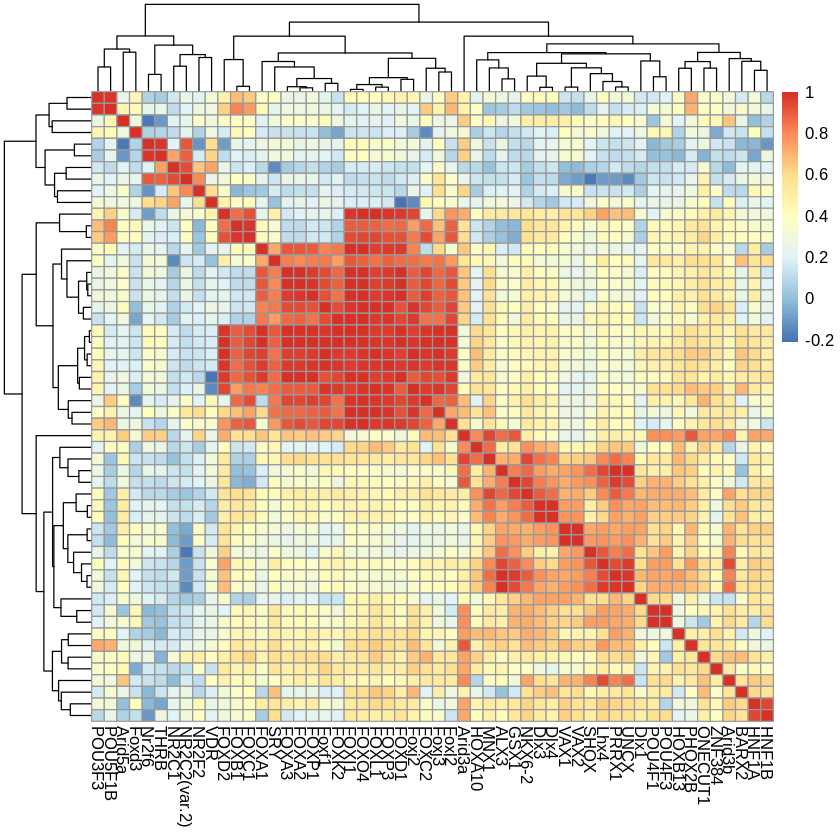

In [155]:
pheatmap(as.matrix(similarity_mtx[, c(-1)]), name = "KL")

In [206]:
gene_pairs

ALX3,ALX3,ALX3,ALX3,ALX3,ALX3,ALX3,ALX3,ALX3,ALX3,⋯,FOXP1,FOXP1,FOXP1,FOXP1,FOXP3,FOXP3,FOXP3,POU3F3,POU3F3,NR2F2
Arid3b,BARX2,GSX1,HOXB13,Lhx4,NKX6-2,PHOX2B,PRRX1,SHOX,UNCX,⋯,FOXP3,POU3F3,NR2F2,Nr2f6,POU3F3,NR2F2,Nr2f6,NR2F2,Nr2f6,Nr2f6


In [207]:
similarity_df_1_euclidean <- data.table()
gene_pairs <- combn(genes_TFs_1,2, simplify = F)
for (gene_pair in gene_pairs){
    print(gene_pair)
    l <- list("TF1" = gene_pair[1], "TF2" = gene_pair[2],
          "corr" = PWMSimilarity(pwm_list[[gene_pair[1]]], pwm_list[[gene_pair[2]]], method = "Pearson"))
   similarity_df_1_euclidean <-  rbind(similarity_df_1_euclidean, l)
    }

[1] "ALX3"   "Arid3b"
[1] "ALX3"  "BARX2"
[1] "ALX3" "GSX1"
[1] "ALX3"   "HOXB13"
[1] "ALX3" "Lhx4"
[1] "ALX3"   "NKX6-2"
[1] "ALX3"   "PHOX2B"
[1] "ALX3"  "PRRX1"
[1] "ALX3" "SHOX"
[1] "ALX3" "UNCX"
[1] "ALX3"   "Arid5a"
[1] "ALX3"  "HNF1A"
[1] "ALX3"  "HNF1B"
[1] "ALX3"   "POU4F1"
[1] "ALX3"   "POU4F3"
[1] "ALX3"    "POU5F1B"
[1] "ALX3"   "Arid3a"
[1] "ALX3"  "FOXB1"
[1] "ALX3"    "ONECUT1"
[1] "ALX3"   "HOXA10"
[1] "ALX3"   "ZNF384"
[1] "ALX3"  "Foxd3"
[1] "ALX3" "VAX2"
[1] "ALX3"  "FOXC1"
[1] "ALX3"  "FOXC2"
[1] "ALX3"  "Foxj2"
[1] "ALX3"  "Foxj3"
[1] "ALX3" "SRY" 
[1] "ALX3" "Dlx1"
[1] "ALX3" "Dlx3"
[1] "ALX3" "Dlx4"
[1] "ALX3" "MNX1"
[1] "ALX3" "VAX1"
[1] "ALX3"  "NR2C1"
[1] "ALX3"         "NR2C2(var.2)"
[1] "ALX3" "THRB"
[1] "ALX3"  "FOXL1"
[1] "ALX3"  "FOXA1"
[1] "ALX3"  "FOXA2"
[1] "ALX3"  "FOXA3"
[1] "ALX3"  "FOXD1"
[1] "ALX3"  "Foxf1"
[1] "ALX3"  "FOXK2"
[1] "ALX3"  "Foxl2"
[1] "ALX3" "VDR" 
[1] "ALX3"  "FOXD2"
[1] "ALX3"  "FOXI1"
[1] "ALX3"  "FOXO4"
[1] "ALX3"  "FOXP1"
[1] 

In [209]:
highly_similar <- similarity_df_1_euclidean %>% filter(corr > 0.8)

In [161]:
tissue_expression <- read.table("../rna_consensus.tsv", sep = "\t", header = 1)

In [162]:
tissue_expression_l <- tissue_expression %>% filter(Tissue == "liver")

In [163]:
setDT(tissue_expression_l)

In [192]:
tissue_expression_l[, isExpressed:=ifelse(NX>1, 1, 0),]

In [166]:
mouse <- read.delim("../MGIgeneExpressionQuery_20201229_181947.txt")
head(mouse)

,MGI.Gene.ID,Gene.Symbol,Gene.Name,MGI.Assay.ID,Assay.Type,Age,Theiler.Stage,Structure,Detected,TPM.Level..RNA.Seq.,⋯,Images,Mutant.Allele.s.,Strain,Sex,Notes..RNA.Seq.,TPM..avg_quantile.normalization.,MGI.Reference.ID,PubMed.ID,Citation,X
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<dbl>,<chr>,<lgl>,<chr>,<lgl>
1,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-2328,RNA-Seq,P4,28,liver,Yes,Medium,⋯,NA,NA,C57BL/6J,,NA,20,E-MTAB-2328,NA,Transcription profiling by high throughput sequencing of liver and brain during mouse organ development,NA
2,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-6798,RNA-Seq,P14,28,heart,Yes,Low,⋯,NA,NA,CD-1,Female,NA,2,E-MTAB-6798,NA,Mouse RNA-seq time-series of the development of seven major organs,NA
3,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-6798,RNA-Seq,P14,28,heart,Yes,Low,⋯,NA,NA,CD-1,Male,NA,2,E-MTAB-6798,NA,Mouse RNA-seq time-series of the development of seven major organs,NA
4,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-6798,RNA-Seq,P14,28,liver,Yes,Low,⋯,NA,NA,CD-1,Male,NA,1,E-MTAB-6798,NA,Mouse RNA-seq time-series of the development of seven major organs,NA
5,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-6798,RNA-Seq,P14,28,liver,Yes,Low,⋯,NA,NA,CD-1,Female,NA,3,E-MTAB-6798,NA,Mouse RNA-seq time-series of the development of seven major organs,NA
6,MGI:1328360,Arid3a,AT rich interactive domain 3A (BRIGHT-like),E-MTAB-599,RNA-Seq,P adult,28,heart,Yes,Low,⋯,NA,NA,(DBA/2J x C57BL/6J)F1,,NA,2,E-MTAB-599,NA,"RNA-seq of mouse DBA/2J x C57BL/6J heart, hippocampus, liver, lung, spleen and thymus",NA


In [190]:
mouse_l <- mouse %>% filter(Structure == "liver") %>% dplyr::select(Gene.Symbol, TPM.Level..RNA.Seq.)
setDT(mouse_l)
mouse_l[, isExpressed:=ifelse(TPM.Level..RNA.Seq. == 'Below Cutoff',0, 1),]
colnames(mouse_l)[[1]] <- "Gene.name"
mouse_l <- unique(mouse_l[, c("Gene.name", "isExpressed")]) %>% group_by(Gene.name) %>% 
                                summarize(isExpressed = max(isExpressed))

`summarise()` ungrouping output (override with `.groups` argument)



In [199]:
expr_l_full <- rbind(mouse_l, tissue_expression_l[,c("Gene.name", "isExpressed")])
setDT(expr_l_full)

In [197]:
highly_similar[1,]$TF1

[1] "ALX3"

In [241]:
genes_to_blacklist <- c()

In [242]:
genes_not_expressed_paired <- c()

In [251]:
genes_to_blacklist <- c()
genes_not_expressed_paired_A <- c()
genes_not_expressed_paired_B <- c()
for (i in 1:NROW(highly_similar)){
geneA = highly_similar[i,]$TF1
geneB = highly_similar[i,]$TF2

subdf <- expr_l_full[Gene.name %in% c(geneA, geneB),]

if(sum(subdf$isExpressed) ==2 ) print("all expressed")
if(sum(subdf$isExpressed) ==0 ) {
    genes_not_expressed_paired_A <- c(genes_not_expressed_paired_A, geneA)
    genes_not_expressed_paired_B <- c(genes_not_expressed_paired_B, geneB)}
if(sum(subdf$isExpressed) ==1 ) genes_to_blacklist <- c(genes_to_blacklist, subdf[subdf$isExpressed == 0, ]$Gene.name)
}

[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"


In [252]:
table(genes_to_blacklist)

genes_to_blacklist
  ALX3   Dlx3  FOXB1  FOXC2  FOXD1  FOXD2  FOXI1  FOXL1  Foxl2   GSX1 HOXA10 
     1      1      3     10     11      4     11     11      9      1      1 
  Lhx4   MNX1 NKX6-2 PHOX2B  PRRX1   SHOX    SRY   UNCX 
     1      2      1      1      1      1      8      1 

In [253]:
length(unique(genes_to_blacklist))

[1] 19

In [256]:
tfs_summary <- expr_l_full[Gene.name %in% genes_TFs_1, ]

In [257]:
tfs_summary[, blacklisted := Gene.name %in% unique(genes_to_blacklist), ]

In [259]:
tfs_summary[, "actTissue" := "Liver", ]

And repeat for the heart:

In [260]:
genes_TFs_2 <- unique(gene_clusters[gene_clusters$cl == 2,]$TF)
similarity_df_2_euclidean <- data.table()
gene_pairs <- combn(genes_TFs_2,2, simplify = F)
for (gene_pair in gene_pairs){
    l <- list("TF1" = gene_pair[1], "TF2" = gene_pair[2],
          "corr" = PWMSimilarity(pwm_list[[gene_pair[1]]], pwm_list[[gene_pair[2]]], method = "Pearson"))
   similarity_df_2_euclidean <-  rbind(similarity_df_2_euclidean, l)
    }

[1] "ELF3" "EGR1"
[1] "ELF3"  "KLF11"
[1] "ELF3"  "KLF16"
[1] "ELF3" "KLF2"
[1] "ELF3" "KLF9"
[1] "ELF3" "SP3" 
[1] "ELF3" "SP9" 
[1] "ELF3" "Wt1" 
[1] "ELF3"   "ZBTB14"
[1] "ELF3" "E2F6"
[1] "ELF3"   "ZNF263"
[1] "ELF3" "EHF" 
[1] "ELF3" "ELF1"
[1] "ELF3" "ELK4"
[1] "ELF3" "ETS1"
[1] "ELF3"  "GABPA"
[1] "ELF3" "KLF4"
[1] "ELF3" "KLF5"
[1] "ELF3" "NFIX"
[1] "ELF3" "SP8" 
[1] "ELF3"   "ZBTB7A"
[1] "ELF3"   "ZNF148"
[1] "ELF3"   "ZNF740"
[1] "ELF3" "ERG" 
[1] "ELF3"        "ARNT::HIF1A"
[1] "ELF3" "ELF5"
[1] "ELF3" "ETV1"
[1] "ELF3" "ETV4"
[1] "ELF3" "ETV5"
[1] "ELF3" "ERF" 
[1] "ELF3" "ETV6"
[1] "ELF3" "FEV" 
[1] "EGR1"  "KLF11"
[1] "EGR1"  "KLF16"
[1] "EGR1" "KLF2"
[1] "EGR1" "KLF9"
[1] "EGR1" "SP3" 
[1] "EGR1" "SP9" 
[1] "EGR1" "Wt1" 
[1] "EGR1"   "ZBTB14"
[1] "EGR1" "E2F6"
[1] "EGR1"   "ZNF263"
[1] "EGR1" "EHF" 
[1] "EGR1" "ELF1"
[1] "EGR1" "ELK4"
[1] "EGR1" "ETS1"
[1] "EGR1"  "GABPA"
[1] "EGR1" "KLF4"
[1] "EGR1" "KLF5"
[1] "EGR1" "NFIX"
[1] "EGR1" "SP8" 
[1] "EGR1"   "ZBTB7A"
[1] "E

In [261]:
highly_similar <- similarity_df_2_euclidean %>% filter(corr > 0.8)

In [262]:
NROW(highly_similar)

[1] 63

In [263]:
similarity_simm = data.table()
for (geneA in genes_TFs_2){
    print(geneA)
    for (geneB in genes_TFs_2){
    l <- list("TF1" = geneA, "TF2" = geneB,
          "KL" = PWMSimilarity(pwm_list[[geneA]], pwm_list[[geneB]], method = "Pearson"))
   similarity_simm <-  rbind(similarity_simm, l)
    }
    }

[1] "ELF3"
[1] "EGR1"
[1] "KLF11"
[1] "KLF16"
[1] "KLF2"
[1] "KLF9"
[1] "SP3"
[1] "SP9"
[1] "Wt1"
[1] "ZBTB14"
[1] "E2F6"
[1] "ZNF263"
[1] "EHF"
[1] "ELF1"
[1] "ELK4"
[1] "ETS1"
[1] "GABPA"
[1] "KLF4"
[1] "KLF5"
[1] "NFIX"
[1] "SP8"
[1] "ZBTB7A"
[1] "ZNF148"
[1] "ZNF740"
[1] "ERG"
[1] "ARNT::HIF1A"
[1] "ELF5"
[1] "ETV1"
[1] "ETV4"
[1] "ETV5"
[1] "ERF"
[1] "ETV6"
[1] "FEV"


In [264]:
similarity_mtx <- similarity_simm %>% spread(TF2, KL)
row.names(similarity_mtx) <- similarity_mtx$TF1

In [273]:
write.table(similarity_simm, "TFBS_corr_heart.tsv", quote = F, row.names = F, sep=";")

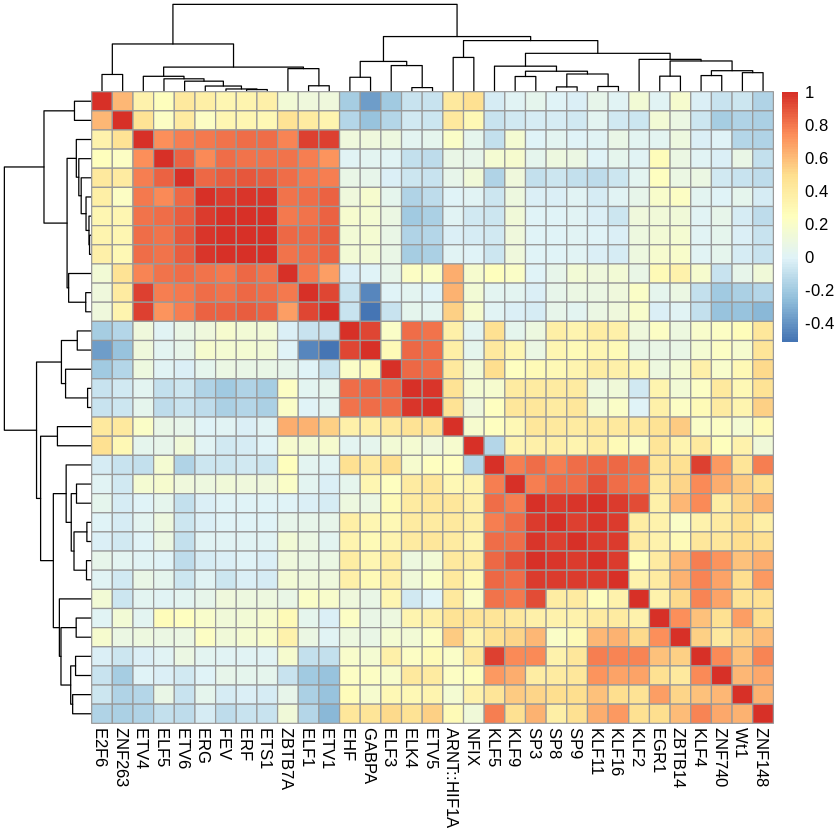

In [265]:
pheatmap(as.matrix(similarity_mtx[, c(-1)]), name = "KL")

In [284]:
tissue_expression_h <- tissue_expression %>% filter(Tissue == "heart muscle")
setDT(tissue_expression_h)

In [285]:
tissue_expression_h[, isExpressed:=ifelse(NX>1, 1, 0),]

In [268]:
mouse_h <- mouse %>% filter(Structure == "heart") %>% dplyr::select(Gene.Symbol, TPM.Level..RNA.Seq.)
setDT(mouse_h)
mouse_h[, isExpressed:=ifelse(TPM.Level..RNA.Seq. == 'Below Cutoff',0, 1),]
colnames(mouse_h)[[1]] <- "Gene.name"
mouse_h <- unique(mouse_h[, c("Gene.name", "isExpressed")]) %>% group_by(Gene.name) %>% 
                                summarize(isExpressed = max(isExpressed))

`summarise()` ungrouping output (override with `.groups` argument)



In [287]:
expr_h_full <- rbind(mouse_h, tissue_expression_h[,c("Gene.name", "isExpressed")])
setDT(expr_h_full)

In [288]:
genes_to_blacklist <- c()
genes_not_expressed_paired_A <- c()
genes_not_expressed_paired_B <- c()
for (i in 1:NROW(highly_similar)){
geneA = highly_similar[i,]$TF1
geneB = highly_similar[i,]$TF2

subdf <- expr_h_full[Gene.name %in% c(geneA, geneB),]

if(sum(subdf$isExpressed) ==2 ) print("all expressed")
if(sum(subdf$isExpressed) ==0 ) {
    genes_not_expressed_paired_A <- c(genes_not_expressed_paired_A, geneA)
    genes_not_expressed_paired_B <- c(genes_not_expressed_paired_B, geneB)}
if(sum(subdf$isExpressed) ==1 ) genes_to_blacklist <- c(genes_to_blacklist, subdf[subdf$isExpressed == 0, ]$Gene.name)
}

[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"
[1] "all expressed"


In [289]:
table(genes_to_blacklist)

genes_to_blacklist
 EHF ELF5  FEV  SP8  SP9 
   3    4    7    4    5 

In [276]:
colnames(tfs_summary)[[2]] <- "isExpressedLiver"

In [291]:
tfs_summary <- left_join(tfs_summary, expr_h_full)

Joining, by = "Gene.name"



In [292]:
colnames(tfs_summary)[[5]] <- "isExpressedHeart"

In [293]:
tfs_summary_tmp <- expr_h_full[Gene.name %in% genes_TFs_2, ]

In [295]:
tfs_summary_tmp[, blacklisted := Gene.name %in% unique(genes_to_blacklist), ]
tfs_summary_tmp[, "actTissue" := "Heart", ]
colnames(tfs_summary_tmp)[[2]] <- "isExpressedHeart"

In [296]:
tfs_summary_tmp <- left_join(tfs_summary_tmp, expr_l_full)

Joining, by = "Gene.name"



In [297]:
colnames(tfs_summary_tmp)[[5]] <- "isExpressedLiver"

In [299]:
tfs_summary <- rbind(tfs_summary, tfs_summary_tmp)

In [301]:
write.table(tfs_summary, "TFs_active_tissues_annotated.tsv", sep = ";", quote= F, row.names = F )

In [308]:
length(names(pwm_list))

[1] 746

In [309]:
expr_full <- full_join(expr_l_full[expr_l_full$Gene.name %in% names(pwm_list),], expr_h_full[expr_h_full$Gene.name %in% names(pwm_list),], by = "Gene.name")

In [310]:
expr_full[expr_full$Gene.name == "FOXP3",]

Gene.name,isExpressed.x,isExpressed.y
<chr>,<dbl>,<dbl>
FOXP3,1,0


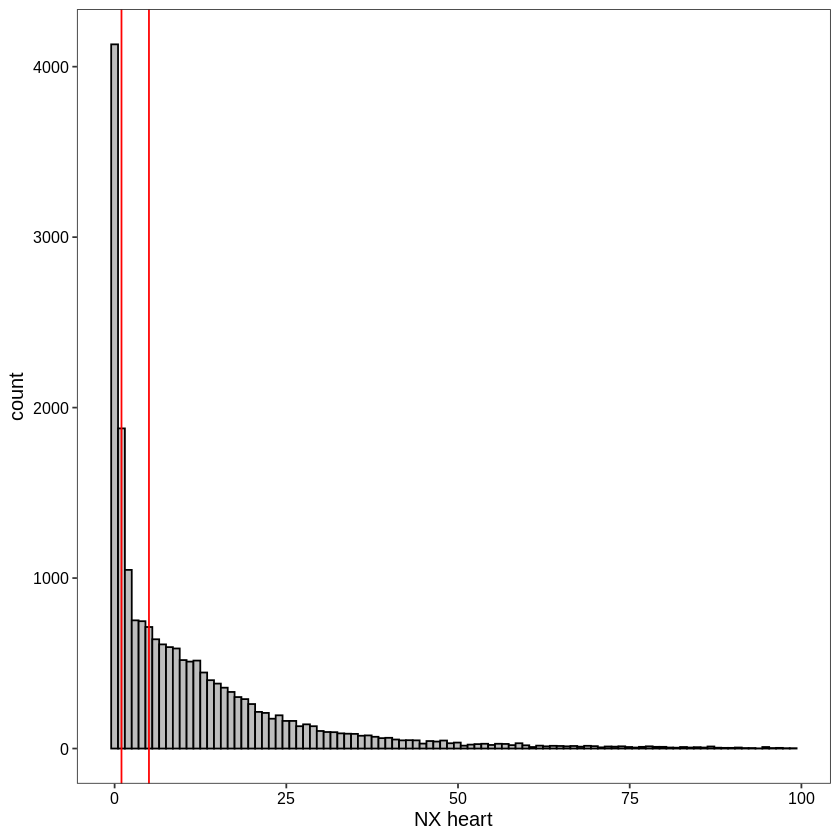

In [319]:
ggplot(tissue_expression_h[tissue_expression_h$NX < 100. ], aes(x = NX) ) + 
geom_histogram(bins = 100, color = "black", fill = "grey") + 
geom_vline(xintercept = 1, color = "red") + geom_vline(xintercept = 5, color = "red") + 
xlab("NX heart")

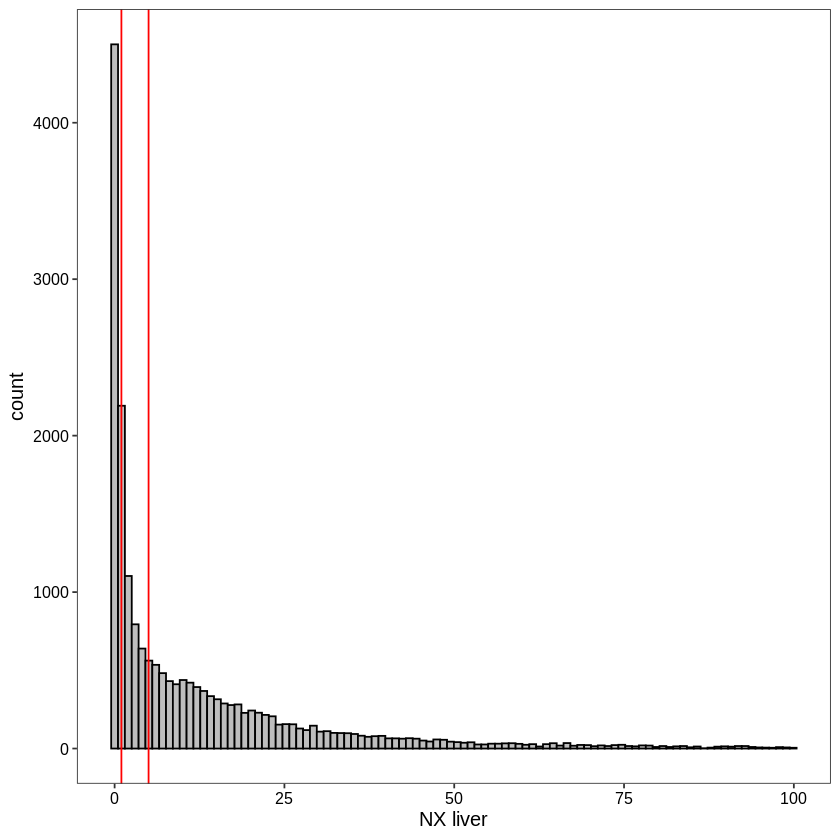

In [321]:
ggplot(tissue_expression_l[tissue_expression_l$NX < 100. ], aes(x = NX) ) + 
geom_histogram(bins = 100, color = "black", fill = "grey") + 
geom_vline(xintercept = 1, color = "red") + geom_vline(xintercept = 5, color = "red") + 
xlab("NX liver")

In [324]:
head(expr_full)

Gene.name,isExpressed.x,isExpressed.y
<chr>,<dbl>,<dbl>
Arid3a,1,1
Arid3b,1,1
Arid5a,1,1
Dlx3,0,0
Dlx4,1,0
Foxd3,0,1


In [325]:
colnames(expr_full) <- c("TF", "expressedLiver", "expressedHeart")

In [329]:
expr_full <- rbind(expr_full, 
      data.table("TF" = setdiff(names(pwm_list), expr_full$Gene.name), "expressedLiver" = NA,"expressedHeart" = NA ))

In [330]:
write.table(expr_full, "all_TFs_annotated.tsv", sep = ";", quote= F, row.names = F )

In [332]:
length(unique(genes_to_blacklist))

[1] 5

In [334]:
length(genes_TFs_2)

[1] 33

In [335]:
getwd()

[1] "/scratch/lab_bock/shared/projects/compEpi/results_analysis/03_motifAnalysis/03.7_AME"